In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from numpy.typing import NDArray
from scipy.optimize import minimize
from typing import List, Tuple
import time as time
import pandas as pd


In [2]:
# 価格を生成する関数
def create_price(r_mean: float, r_std: float, M: int) -> NDArray[np.float_]:
    # r_mean = (r_min + r_max) / 2
    # r_std = (r_max - r_mean) / 2
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.normal(r_mean, r_std, size=M)
    # price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-3 * M, -2 * M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 3)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


def create_date(M, N, r_mean, r_std, delta=0.1):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(r_mean, r_std, M)
        quantity = quantity_function(price, alpha, beta, delta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y


def create_bounds(M, r_min, r_max):
    lb = np.full(M, r_min)
    ub = np.full(M, r_max)

    range_bounds = []
    for i in range(M):
        range_bounds.append(lb[i])

    for i in range(M):
        range_bounds.append(ub[i])

    bounds = [(r_min, r_max) for _ in range(M)]

    return lb, ub, bounds, range_bounds


In [3]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    bounds: list[tuple[float, float]],
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)

    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [4]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [5]:
# CVを行う関数
def cross_validation(
    tilda_coefs_list: list[NDArray[np.float_]],
    tilda_intercepts_list: list[float],
    hat_coefs_list: list[NDArray[np.float_]],
    hat_intercepts_list: list[float],
    M: int,
    K: int,
    bounds: list[float],
) -> float:
    optimal_sales_list = []

    for i in range(K):
        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(tilda_intercepts_list[i], tilda_coefs_list[i], M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        # print("optimal_prices cv:", optimal_prices)

        sales_hat = np.sum(
            sales_function(optimal_prices, hat_intercepts_list[i], hat_coefs_list[i])
        )

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


In [6]:
### 変更後の cross_validation_bounds_zero_2
def cross_validation_bounds(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
) -> float:
    # bounds から (low, high) の形式に変換
    bounds_list = []
    for i in range(M):
        if bounds[i] > bounds[i + M]:
            bounds_mean = (bounds[i] + bounds[i + M]) / 2
            bounds_list.append((bounds_mean, bounds_mean))
        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    optimal_sales_list = []

    for i in range(K):
        # tildaパラメータで最適化（学習済み）
        intercepts = tilda_intercepts_list[i]
        coefs = tilda_coefs_list[i]

        initial_prices = np.full(M, 0.6)
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        optimal_prices = result.x

        # 得られた最適価格でhatパラメータに基づく売上計算
        alpha = hat_intercepts_list[i]
        beta = hat_coefs_list[i]

        sales_hat = np.sum(sales_function(optimal_prices, alpha, beta))
        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_nelder(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    r_min: float,
    r_max: float,
    adaptive: bool = True,
) -> Tuple[float, List[Tuple[float, float]]]:
    # Nelder-Meadでの最適化
    bounds_nelder = minimize(
        cross_validation_bounds,
        bounds,
        args=(tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        lb = min(bounds_nelder.x[i], bounds_nelder.x[i + M])
        ub = max(bounds_nelder.x[i], bounds_nelder.x[i + M])
        opt_bounds.append((lb, ub))

    return -bounds_nelder.fun, opt_bounds


In [7]:
def cross_validation_bounds_penalty_all(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    bounds_range: float,
    lamda: float,
) -> float:
    # bounds の整合性チェック
    bounds_list = []
    for i in range(M):
        if bounds[i] > bounds[i + M]:
            bounds_mean = (bounds[i] + bounds[i + M]) / 2
            bounds_list.append((bounds_mean, bounds_mean))
        else:
            bounds_list.append((bounds[i], bounds[i + M]))
    optimal_sales_list = []

    # すでに外部でKFold分割や学習が終わっているものとして
    # tilda_coefs_list[i], tilda_intercepts_list[i], hat_coefs_list[i], hat_intercepts_list[i]
    # を使用して最適化と売上計算
    for i in range(K):
        intercepts = tilda_intercepts_list[i]
        coefs = tilda_coefs_list[i]

        # 最適化
        initial_prices = np.full(M, 0.6)
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        optimal_prices = result.x

        # hatモデルパラメータで売上計算
        alpha = hat_intercepts_list[i]
        beta = hat_coefs_list[i]

        sales_hat = np.sum(sales_function(optimal_prices, alpha, beta))
        optimal_sales_list.append(sales_hat)

    # ペナルティ計算
    penalty = 0.0
    for i in range(M):
        penalty += bounds[i + M] - bounds[i]

    mean_sales = np.mean(optimal_sales_list)

    return -mean_sales + lamda * max(0, penalty - M * bounds_range) ** 2


def estimate_bounds_penalty_nelder_all(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    r_min: float,
    r_max: float,
    bounds_range: float,
    lamda: float,
    adaptive: bool = True,
) -> Tuple[float, List[Tuple[float, float]]]:
    # Nelder-Meadでの最適化
    bounds_nelder = minimize(
        cross_validation_bounds_penalty_all,
        bounds,
        args=(
            tilda_coefs_list,
            tilda_intercepts_list,
            hat_coefs_list,
            hat_intercepts_list,
            M,
            K,
            bounds_range,
            lamda,
        ),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        lb = min(bounds_nelder.x[i], bounds_nelder.x[i + M])
        ub = max(bounds_nelder.x[i], bounds_nelder.x[i + M])
        opt_bounds.append((lb, ub))

    return -bounds_nelder.fun, opt_bounds


In [8]:
# 実験設定

M = 10
K = 5
N = 500
r_mean = 0.8
r_std = 0.1
r_min = 0.5
r_max = 1.1
delta = 0.6
z_range = 0.4
lb, ub, bounds, range_bounds = create_bounds(M, r_min, r_max)


# 100回実験を行う
so_sales_list_5 = []
po_sales_list_5 = []
true_po_sales_list_5 = []
cv_sales_list_5 = []

ebz_po_sales_list_5 = []
true_ebz_po_sales_list_5 = []


ebpa3_po_sales_list_5 = []
true_ebpa3_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa5_po_sales_list_5 = []
true_ebpa5_po_sales_list_5 = []

ebz_range_deff_list_5 = []
ebpa3_range_deff_list_5 = []
ebpa4_range_deff_list_5 = []
ebpa5_range_deff_list_5 = []


for _ in range(100):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta)
    tilda_coefs_list = []
    tilda_intercepts_list = []
    hat_coefs_list = []
    hat_intercepts_list = []
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        tilda_coefs_list.append(coefs)
        tilda_intercepts_list.append(intercepts)

        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        hat_coefs = [estimate.coef_ for estimate in lr_hat.estimators_]
        hat_intercepts = [estimate.intercept_ for estimate in lr_hat.estimators_]

        hat_coefs_list.append(hat_coefs)
        hat_intercepts_list.append(hat_intercepts)

    # SO
    so_sales, so_prices = sales_optimize(M, alpha, beta, bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, bounds)
    true_po_sales = np.sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(
        tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K, bounds
    )

    so_sales_list_5.append(so_sales / so_sales)
    po_sales_list_5.append(po_sales / so_sales)
    true_po_sales_list_5.append(true_po_sales / so_sales)
    cv_sales_list_5.append(cv_sales / so_sales)

    # EBZ
    ebz_val, ebz_bounds = estimate_bounds_nelder(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = np.sum(sales_function(ebz_po_prices, alpha, beta))
    cv_ebz_sales = cross_validation(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        ebz_bounds,
    )

    ebz_po_sales_list_5.append(ebz_po_sales / so_sales)
    true_ebz_po_sales_list_5.append(true_ebz_po_sales / so_sales)

    # EBPA(0.3)
    ebpa3_val, ebpa3_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.30,
        1.0,
    )

    ebpa3_po_sales, ebpa3_po_prices = predict_optimize(M, X, Y, ebpa3_bounds)
    true_ebpa_po_sales = np.sum(sales_function(ebpa3_po_prices, alpha, beta))

    ebpa3_po_sales_list_5.append(ebpa3_po_sales / so_sales)
    true_ebpa3_po_sales_list_5.append(true_ebpa_po_sales / so_sales)

    # EBPA(0.4)
    ebpa4_val, ebpa4_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.40,
        1.0,
    )

    ebpa4_po_sales, ebpa4_po_prices = predict_optimize(M, X, Y, ebpa4_bounds)
    true_ebpa4_po_sales = np.sum(sales_function(ebpa4_po_prices, alpha, beta))

    ebpa4_po_sales_list_5.append(ebpa4_po_sales / so_sales)
    true_ebpa4_po_sales_list_5.append(true_ebpa4_po_sales / so_sales)

    # EBPA(0.5)
    ebpa5_val, ebpa5_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.50,
        1.0,
    )

    ebpa5_po_sales, ebpa5_po_prices = predict_optimize(M, X, Y, ebpa5_bounds)
    true_ebpa5_po_sales = np.sum(sales_function(ebpa5_po_prices, alpha, beta))

    ebpa5_po_sales_list_5.append(ebpa5_po_sales / so_sales)
    true_ebpa5_po_sales_list_5.append(true_ebpa5_po_sales / so_sales)

    ebz_range_deff_list = [ebz_bounds[i][1] - ebz_bounds[i][0] for i in range(M)]
    ebpa3_range_deff_list = [ebpa3_bounds[i][1] - ebpa3_bounds[i][0] for i in range(M)]
    ebpa4_range_deff_list = [ebpa4_bounds[i][1] - ebpa4_bounds[i][0] for i in range(M)]
    ebpa5_range_deff_list = [ebpa5_bounds[i][1] - ebpa5_bounds[i][0] for i in range(M)]

    ebz_range_deff_list_5.append(np.mean(ebz_range_deff_list))
    ebpa3_range_deff_list_5.append(np.mean(ebpa3_range_deff_list))
    ebpa4_range_deff_list_5.append(np.mean(ebpa4_range_deff_list))
    ebpa5_range_deff_list_5.append(np.mean(ebpa5_range_deff_list))


In [9]:
# dfにまとめる
df_10_6 = pd.DataFrame(
    {
        "SO": so_sales_list_5,
        "PO": po_sales_list_5,
        "True PO": true_po_sales_list_5,
        "CV": cv_sales_list_5,
        "EBZ": ebz_po_sales_list_5,
        "True EBZ": true_ebz_po_sales_list_5,
        "EBPA(0.3)": ebpa3_po_sales_list_5,
        "True EBPA(0.3)": true_ebpa3_po_sales_list_5,
        "EBPA(0.4)": ebpa4_po_sales_list_5,
        "True EBPA(0.4)": true_ebpa4_po_sales_list_5,
        "EBPA(0.5)": ebpa5_po_sales_list_5,
        "True EBPA(0.5)": true_ebpa5_po_sales_list_5,
        "EBZ Range": ebz_range_deff_list_5,
        "EBPA(0.3) Range": ebpa3_range_deff_list_5,
        "EBPA(0.4) Range": ebpa4_range_deff_list_5,
        "EBPA(0.5) Range": ebpa5_range_deff_list_5,
    }
)

df_10_6.to_csv("df_10_6.csv")


In [10]:
# 実験設定

M = 10
K = 5
N = 500
r_mean = 0.8
r_std = 0.1
r_min = 0.5
r_max = 1.1
delta = 0.8
z_range = 0.4
lb, ub, bounds, range_bounds = create_bounds(M, r_min, r_max)


# 100回実験を行う
so_sales_list_5 = []
po_sales_list_5 = []
true_po_sales_list_5 = []
cv_sales_list_5 = []

ebz_po_sales_list_5 = []
true_ebz_po_sales_list_5 = []


ebpa3_po_sales_list_5 = []
true_ebpa3_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa5_po_sales_list_5 = []
true_ebpa5_po_sales_list_5 = []

ebz_range_deff_list_5 = []
ebpa3_range_deff_list_5 = []
ebpa4_range_deff_list_5 = []
ebpa5_range_deff_list_5 = []


for _ in range(100):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta)
    tilda_coefs_list = []
    tilda_intercepts_list = []
    hat_coefs_list = []
    hat_intercepts_list = []
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        tilda_coefs_list.append(coefs)
        tilda_intercepts_list.append(intercepts)

        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        hat_coefs = [estimate.coef_ for estimate in lr_hat.estimators_]
        hat_intercepts = [estimate.intercept_ for estimate in lr_hat.estimators_]

        hat_coefs_list.append(hat_coefs)
        hat_intercepts_list.append(hat_intercepts)

    # SO
    so_sales, so_prices = sales_optimize(M, alpha, beta, bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, bounds)
    true_po_sales = np.sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(
        tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K, bounds
    )

    so_sales_list_5.append(so_sales / so_sales)
    po_sales_list_5.append(po_sales / so_sales)
    true_po_sales_list_5.append(true_po_sales / so_sales)
    cv_sales_list_5.append(cv_sales / so_sales)

    # EBZ
    ebz_val, ebz_bounds = estimate_bounds_nelder(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = np.sum(sales_function(ebz_po_prices, alpha, beta))
    cv_ebz_sales = cross_validation(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        ebz_bounds,
    )

    ebz_po_sales_list_5.append(ebz_po_sales / so_sales)
    true_ebz_po_sales_list_5.append(true_ebz_po_sales / so_sales)

    # EBPA(0.3)
    ebpa3_val, ebpa3_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.30,
        1.0,
    )

    ebpa3_po_sales, ebpa3_po_prices = predict_optimize(M, X, Y, ebpa3_bounds)
    true_ebpa_po_sales = np.sum(sales_function(ebpa3_po_prices, alpha, beta))

    ebpa3_po_sales_list_5.append(ebpa3_po_sales / so_sales)
    true_ebpa3_po_sales_list_5.append(true_ebpa_po_sales / so_sales)

    # EBPA(0.4)
    ebpa4_val, ebpa4_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.40,
        1.0,
    )

    ebpa4_po_sales, ebpa4_po_prices = predict_optimize(M, X, Y, ebpa4_bounds)
    true_ebpa4_po_sales = np.sum(sales_function(ebpa4_po_prices, alpha, beta))

    ebpa4_po_sales_list_5.append(ebpa4_po_sales / so_sales)
    true_ebpa4_po_sales_list_5.append(true_ebpa4_po_sales / so_sales)

    # EBPA(0.5)
    ebpa5_val, ebpa5_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.50,
        1.0,
    )

    ebpa5_po_sales, ebpa5_po_prices = predict_optimize(M, X, Y, ebpa5_bounds)
    true_ebpa5_po_sales = np.sum(sales_function(ebpa5_po_prices, alpha, beta))

    ebpa5_po_sales_list_5.append(ebpa5_po_sales / so_sales)
    true_ebpa5_po_sales_list_5.append(true_ebpa5_po_sales / so_sales)

    ebz_range_deff_list = [ebz_bounds[i][1] - ebz_bounds[i][0] for i in range(M)]
    ebpa3_range_deff_list = [ebpa3_bounds[i][1] - ebpa3_bounds[i][0] for i in range(M)]
    ebpa4_range_deff_list = [ebpa4_bounds[i][1] - ebpa4_bounds[i][0] for i in range(M)]
    ebpa5_range_deff_list = [ebpa5_bounds[i][1] - ebpa5_bounds[i][0] for i in range(M)]

    ebz_range_deff_list_5.append(np.mean(ebz_range_deff_list))
    ebpa3_range_deff_list_5.append(np.mean(ebpa3_range_deff_list))
    ebpa4_range_deff_list_5.append(np.mean(ebpa4_range_deff_list))
    ebpa5_range_deff_list_5.append(np.mean(ebpa5_range_deff_list))


In [11]:
# dfにまとめる
df_10_8 = pd.DataFrame(
    {
        "SO": so_sales_list_5,
        "PO": po_sales_list_5,
        "True PO": true_po_sales_list_5,
        "CV": cv_sales_list_5,
        "EBZ": ebz_po_sales_list_5,
        "True EBZ": true_ebz_po_sales_list_5,
        "EBPA(0.3)": ebpa3_po_sales_list_5,
        "True EBPA(0.3)": true_ebpa3_po_sales_list_5,
        "EBPA(0.4)": ebpa4_po_sales_list_5,
        "True EBPA(0.4)": true_ebpa4_po_sales_list_5,
        "EBPA(0.5)": ebpa5_po_sales_list_5,
        "True EBPA(0.5)": true_ebpa5_po_sales_list_5,
        "EBZ Range": ebz_range_deff_list_5,
        "EBPA(0.3) Range": ebpa3_range_deff_list_5,
        "EBPA(0.4) Range": ebpa4_range_deff_list_5,
        "EBPA(0.5) Range": ebpa5_range_deff_list_5,
    }
)

df_10_8.to_csv("df_10_8.csv")


In [12]:
# 実験設定

M = 10
K = 5
N = 500
r_mean = 0.8
r_std = 0.1
r_min = 0.5
r_max = 1.1
delta = 1.0
z_range = 0.4
lb, ub, bounds, range_bounds = create_bounds(M, r_min, r_max)


# 100回実験を行う
so_sales_list_5 = []
po_sales_list_5 = []
true_po_sales_list_5 = []
cv_sales_list_5 = []

ebz_po_sales_list_5 = []
true_ebz_po_sales_list_5 = []


ebpa3_po_sales_list_5 = []
true_ebpa3_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa4_po_sales_list_5 = []
true_ebpa4_po_sales_list_5 = []

ebpa5_po_sales_list_5 = []
true_ebpa5_po_sales_list_5 = []

ebz_range_deff_list_5 = []
ebpa3_range_deff_list_5 = []
ebpa4_range_deff_list_5 = []
ebpa5_range_deff_list_5 = []


for _ in range(100):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta)
    tilda_coefs_list = []
    tilda_intercepts_list = []
    hat_coefs_list = []
    hat_intercepts_list = []
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        tilda_coefs_list.append(coefs)
        tilda_intercepts_list.append(intercepts)

        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        hat_coefs = [estimate.coef_ for estimate in lr_hat.estimators_]
        hat_intercepts = [estimate.intercept_ for estimate in lr_hat.estimators_]

        hat_coefs_list.append(hat_coefs)
        hat_intercepts_list.append(hat_intercepts)

    # SO
    so_sales, so_prices = sales_optimize(M, alpha, beta, bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, bounds)
    true_po_sales = np.sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(
        tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K, bounds
    )

    so_sales_list_5.append(so_sales / so_sales)
    po_sales_list_5.append(po_sales / so_sales)
    true_po_sales_list_5.append(true_po_sales / so_sales)
    cv_sales_list_5.append(cv_sales / so_sales)

    # EBZ
    ebz_val, ebz_bounds = estimate_bounds_nelder(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = np.sum(sales_function(ebz_po_prices, alpha, beta))
    cv_ebz_sales = cross_validation(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        ebz_bounds,
    )

    ebz_po_sales_list_5.append(ebz_po_sales / so_sales)
    true_ebz_po_sales_list_5.append(true_ebz_po_sales / so_sales)

    # EBPA(0.3)
    ebpa3_val, ebpa3_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.30,
        1.0,
    )

    ebpa3_po_sales, ebpa3_po_prices = predict_optimize(M, X, Y, ebpa3_bounds)
    true_ebpa_po_sales = np.sum(sales_function(ebpa3_po_prices, alpha, beta))

    ebpa3_po_sales_list_5.append(ebpa3_po_sales / so_sales)
    true_ebpa3_po_sales_list_5.append(true_ebpa_po_sales / so_sales)

    # EBPA(0.4)
    ebpa4_val, ebpa4_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.40,
        1.0,
    )

    ebpa4_po_sales, ebpa4_po_prices = predict_optimize(M, X, Y, ebpa4_bounds)
    true_ebpa4_po_sales = np.sum(sales_function(ebpa4_po_prices, alpha, beta))

    ebpa4_po_sales_list_5.append(ebpa4_po_sales / so_sales)
    true_ebpa4_po_sales_list_5.append(true_ebpa4_po_sales / so_sales)

    # EBPA(0.5)
    ebpa5_val, ebpa5_bounds = estimate_bounds_penalty_nelder_all(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        0.50,
        1.0,
    )

    ebpa5_po_sales, ebpa5_po_prices = predict_optimize(M, X, Y, ebpa5_bounds)
    true_ebpa5_po_sales = np.sum(sales_function(ebpa5_po_prices, alpha, beta))

    ebpa5_po_sales_list_5.append(ebpa5_po_sales / so_sales)
    true_ebpa5_po_sales_list_5.append(true_ebpa5_po_sales / so_sales)

    ebz_range_deff_list = [ebz_bounds[i][1] - ebz_bounds[i][0] for i in range(M)]
    ebpa3_range_deff_list = [ebpa3_bounds[i][1] - ebpa3_bounds[i][0] for i in range(M)]
    ebpa4_range_deff_list = [ebpa4_bounds[i][1] - ebpa4_bounds[i][0] for i in range(M)]
    ebpa5_range_deff_list = [ebpa5_bounds[i][1] - ebpa5_bounds[i][0] for i in range(M)]

    ebz_range_deff_list_5.append(np.mean(ebz_range_deff_list))
    ebpa3_range_deff_list_5.append(np.mean(ebpa3_range_deff_list))
    ebpa4_range_deff_list_5.append(np.mean(ebpa4_range_deff_list))
    ebpa5_range_deff_list_5.append(np.mean(ebpa5_range_deff_list))


In [13]:
# dfにまとめる
df_10_10 = pd.DataFrame(
    {
        "SO": so_sales_list_5,
        "PO": po_sales_list_5,
        "True PO": true_po_sales_list_5,
        "CV": cv_sales_list_5,
        "EBZ": ebz_po_sales_list_5,
        "True EBZ": true_ebz_po_sales_list_5,
        "EBPA(0.3)": ebpa3_po_sales_list_5,
        "True EBPA(0.3)": true_ebpa3_po_sales_list_5,
        "EBPA(0.4)": ebpa4_po_sales_list_5,
        "True EBPA(0.4)": true_ebpa4_po_sales_list_5,
        "EBPA(0.5)": ebpa5_po_sales_list_5,
        "True EBPA(0.5)": true_ebpa5_po_sales_list_5,
        "EBZ Range": ebz_range_deff_list_5,
        "EBPA(0.3) Range": ebpa3_range_deff_list_5,
        "EBPA(0.4) Range": ebpa4_range_deff_list_5,
        "EBPA(0.5) Range": ebpa5_range_deff_list_5,
    }
)

df_10_10.to_csv("df_10_10.csv")


In [14]:
df_10_10_mean = df_10_10.mean()
df_10_10_std = df_10_10.std()
df_10_10_err = df_10_10_std / np.sqrt(100)


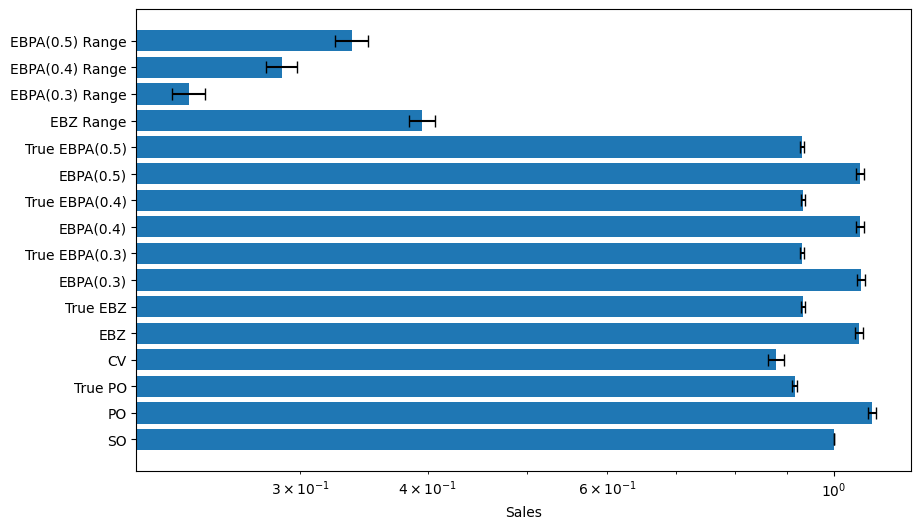

In [15]:
plt.figure(figsize=(10, 6))
plt.barh(df_5_10_mean.index, df_5_10_mean, xerr=df_5_10_err, capsize=4)
plt.xlabel("Sales")
plt.xscale("log")
